In [149]:
import pandas as pd
import numpy as np 
import seaborn as sns
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase 
from matplotlib import colormaps as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import networkx as nx
import pyballmapper as pbm

from sklearn.preprocessing import MinMaxScaler

In [150]:
# Replace with your actual path if different
file_path = "/Users/alexander/Documents/MSc Data Science/erp-uom/data/dataErrors.csv"

# Load the CSV file
df = pd.read_csv(file_path)

In [151]:
# Columns you want to exclude from multiplication
exclude_cols = [
    'religious_fractionalization', 'ethnic_fractionalization',
    'total_spending', 'enp_votes', 'electoral_density','ols_residuals',
    'sem_2015_residuals','slag_struct_residuals','serror_struct_residuals'
]

# 1) Full list of target columns from col 7 to 51 (0-based, so col 7 is index 7, col 51 is index 51)
all_cols = df.columns[3:17]  # .columns[7:52] gets columns 7–51 inclusive

# Filter to get columns to multiply: all minus excluded ones
cols_to_multiply = [col for col in all_cols if col not in exclude_cols]

# Multiply these columns by 100
df[cols_to_multiply] = df[cols_to_multiply] * 100.0

# Variables to scale from 0 to 100
vars_to_scale = [
    'religious_fractionalization', 'ethnic_fractionalization',
    'total_spending', 'enp_votes'
]

# Function to apply MinMaxScaler and return a DataFrame
def minmax_scale_0_100(group):
    scaler = MinMaxScaler()
    group[vars_to_scale] = scaler.fit_transform(group[vars_to_scale]) * 100.0
    return group

# Apply per election year
df = df.groupby('election_year', group_keys=False, observed=True).apply(
    minmax_scale_0_100
)

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_2860/2932965623.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('election_year', group_keys=False, observed=True).apply(


## 1. OLS Residuals

### 2010

In [154]:
# 1. Define diverging colormap for residuals
cmap = plt.cm.bwr
abs_max = np.max(np.abs(df['ols_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 2. Select features and filter year
vars2 = [
    "vote_share_margin",
    "enp_votes",
    "total_spending",
    "c11Unemployed",
    "c11FulltimeStudent",
    "c11HouseOwned",
    "ethnic_fractionalization",
    "religious_fractionalization",
    "c11QualLevel4",
    "age_65_plus",
    "male"
]
df_2010 = df[df['election_year'] == 2010].reset_index(drop=True)
X = df_2010[vars2]
color_df = df_2010[['ols_residuals']]

# 3. Create BallMapper object
bm2010 = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 4. Assign node colours based on residuals
for node in bm2010.Graph.nodes:
    val = bm2010.Graph.nodes[node]['ols_residuals']
    if val is not None and not np.isnan(val):
        bm2010.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2010.Graph.nodes[node]['color'] = "black"

# 5. Plot topology
# don't pre-create a figure
ax = bm2010.draw_networkx(
    coloring_variable='ols_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin, vmax=vmax,
    MIN_SCALE=100, MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2010) - OLS Residuals")

# Close the figure backing that Axes
plt.close(ax.figure)

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [155]:
# 6. Extract balls and metadata
pb2010 = bm2010.points_and_balls()
df_2010['point'] = df_2010.index
points2010 = df_2010.merge(pb2010, on='point')

ball_summary = points2010.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('ols_residuals', 'mean'),  # optional (bias)
    abs_residual_mean=('ols_residuals', lambda x: np.mean(np.abs(x))),  # ← this is key
    residual_std=('ols_residuals', 'std')  # optional
).reset_index()

feature_means = points2010.groupby('ball')[vars2].mean().reset_index()

ball_stats2010_ols = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2010_ols['election_year'] = 2010

### 2015

In [157]:
# 1. Filter 2015 data
df_2015 = df[df['election_year'] == 2015].reset_index(drop=True)
X = df_2015[vars2]
color_df = df_2015[['ols_residuals']]

# 2. Create BallMapper object
bm2015 = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 3. Assign node colours based on residuals
for node in bm2015.Graph.nodes:
    val = bm2015.Graph.nodes[node]['ols_residuals']
    if val is not None and not np.isnan(val):
        bm2015.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2015.Graph.nodes[node]['color'] = "black"

# 4. Plot topology
ax = bm2015.draw_networkx(
    coloring_variable='ols_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2015) - OLS Residuals")

# Close the figure backing that Axes
plt.close(ax.figure)

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [158]:
# 5. Extract balls and metadata
pb2015 = bm2015.points_and_balls()
df_2015['point'] = df_2015.index
points2015 = df_2015.merge(pb2015, on='point')

ball_summary = points2015.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('ols_residuals', 'mean'),  # optional (bias)
    abs_residual_mean=('ols_residuals', lambda x: np.mean(np.abs(x))),  # ← this is key
    residual_std=('ols_residuals', 'std')  # optional
).reset_index()

feature_means = points2015.groupby('ball')[vars2].mean().reset_index()

ball_stats2015_ols = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2015_ols['election_year'] = 2015


### 2017

In [160]:
# 1. Filter 2017 data
df_2017 = df[df['election_year'] == 2017].reset_index(drop=True)
X = df_2017[vars2]
color_df = df_2017[['ols_residuals']]

# 2. Create BallMapper object
bm2017 = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 3. Assign node colours based on residuals
for node in bm2017.Graph.nodes:
    val = bm2017.Graph.nodes[node]['ols_residuals']
    if val is not None and not np.isnan(val):
        bm2017.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2017.Graph.nodes[node]['color'] = "black"

# 4. Plot topology
ax = bm2017.draw_networkx(
    coloring_variable='ols_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2017) - OLS Residuals")

# Close the figure backing that Axes
plt.close(ax.figure)

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [161]:
# 5. Extract balls and metadata
pb2017 = bm2017.points_and_balls()
df_2017['point'] = df_2017.index
points2017 = df_2017.merge(pb2017, on='point')

ball_summary = points2017.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('ols_residuals', 'mean'),  # optional (bias)
    abs_residual_mean=('ols_residuals', lambda x: np.mean(np.abs(x))),  # ← this is key
    residual_std=('ols_residuals', 'std')  # optional
).reset_index()

feature_means = points2017.groupby('ball')[vars2].mean().reset_index()

ball_stats2017_ols = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2017_ols['election_year'] = 2017


### 2019

In [163]:
# 1. Filter 2019 data
df_2019 = df[df['election_year'] == 2019].reset_index(drop=True)
X = df_2019[vars2]
color_df = df_2019[['ols_residuals']]

# 2. Create BallMapper object
bm2019 = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 3. Assign node colours based on residuals
for node in bm2019.Graph.nodes:
    val = bm2019.Graph.nodes[node]['ols_residuals']
    if val is not None and not np.isnan(val):
        bm2019.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2019.Graph.nodes[node]['color'] = "black"

# 4. Plot topology
ax = bm2019.draw_networkx(
    coloring_variable='ols_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2019) - OLS Residuals")


# Close the figure backing that Axes
plt.close(ax.figure)

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [164]:
# 5. Extract balls and metadata
pb2019 = bm2019.points_and_balls()
df_2019['point'] = df_2019.index
points2019 = df_2019.merge(pb2019, on='point')

ball_summary = points2019.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('ols_residuals', 'mean'),  # optional (bias)
    abs_residual_mean=('ols_residuals', lambda x: np.mean(np.abs(x))),  # ← this is key
    residual_std=('ols_residuals', 'std')  # optional
).reset_index()

feature_means = points2019.groupby('ball')[vars2].mean().reset_index()

ball_stats2019_ols = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2019_ols['election_year'] = 2019

In [165]:
# Step 1: Compute absolute residuals
df['abs_ols_residuals'] = df['ols_residuals'].abs()

# Step 2: Compute per-year mean and SD of abs residuals
abs_mean_sd_table = df.groupby('election_year')['abs_ols_residuals'].agg(['mean', 'std']).reset_index()

# Step 3: Compute global mean and SD of abs residuals
global_abs_mean = df['abs_ols_residuals'].mean()
global_abs_sd = df['abs_ols_residuals'].std()

# Step 4: Local (per-year) classification with 0.5 SD threshold
def tag_abs_residual_category(stats_df, year):
    mean_val = abs_mean_sd_table.loc[abs_mean_sd_table['election_year'] == year, 'mean'].values[0]
    std_val = abs_mean_sd_table.loc[abs_mean_sd_table['election_year'] == year, 'std'].values[0]

    def label(row):
        if row['abs_residual_mean'] > mean_val + 0.5 * std_val:
            return 'low'
        else:
            return 'normal'

    stats_df['residual_category'] = stats_df.apply(label, axis=1)
    return stats_df

# Step 5: Global classification with 0.5 SD threshold
def tag_abs_residual_category_global(stats_df):
    def label(row):
        if row['abs_residual_mean'] > global_abs_mean + 0.5 * global_abs_sd:
            return 'low'
        else:
            return 'normal'

    stats_df['residual_category_global'] = stats_df.apply(label, axis=1)
    return stats_df

# Step 6: Combined classification — if either is low
def tag_abs_residual_category_combined(stats_df):
    def label(row):
        if row['residual_category'] == 'low' or row['residual_category_global'] == 'low':
            return 'low'
        else:
            return 'normal'
    stats_df['residual_category_combined'] = stats_df.apply(label, axis=1)
    return stats_df

# Step 7: Apply all taggers to each year
def apply_all_abs_residual_labels(stats_df, year):
    stats_df = tag_abs_residual_category(stats_df, year)
    stats_df = tag_abs_residual_category_global(stats_df)
    stats_df = tag_abs_residual_category_combined(stats_df)
    return stats_df

# Step 8: Apply to per-year data
ball_stats2010_ols = apply_all_abs_residual_labels(ball_stats2010_ols, 2010)
ball_stats2015_ols = apply_all_abs_residual_labels(ball_stats2015_ols, 2015)
ball_stats2017_ols = apply_all_abs_residual_labels(ball_stats2017_ols, 2017)
ball_stats2019_ols = apply_all_abs_residual_labels(ball_stats2019_ols, 2019)

# Step 9: Combine into full DataFrame
ball_stats_ols_all = pd.concat(
    [ball_stats2010_ols, ball_stats2015_ols, ball_stats2017_ols, ball_stats2019_ols],
    ignore_index=True
)


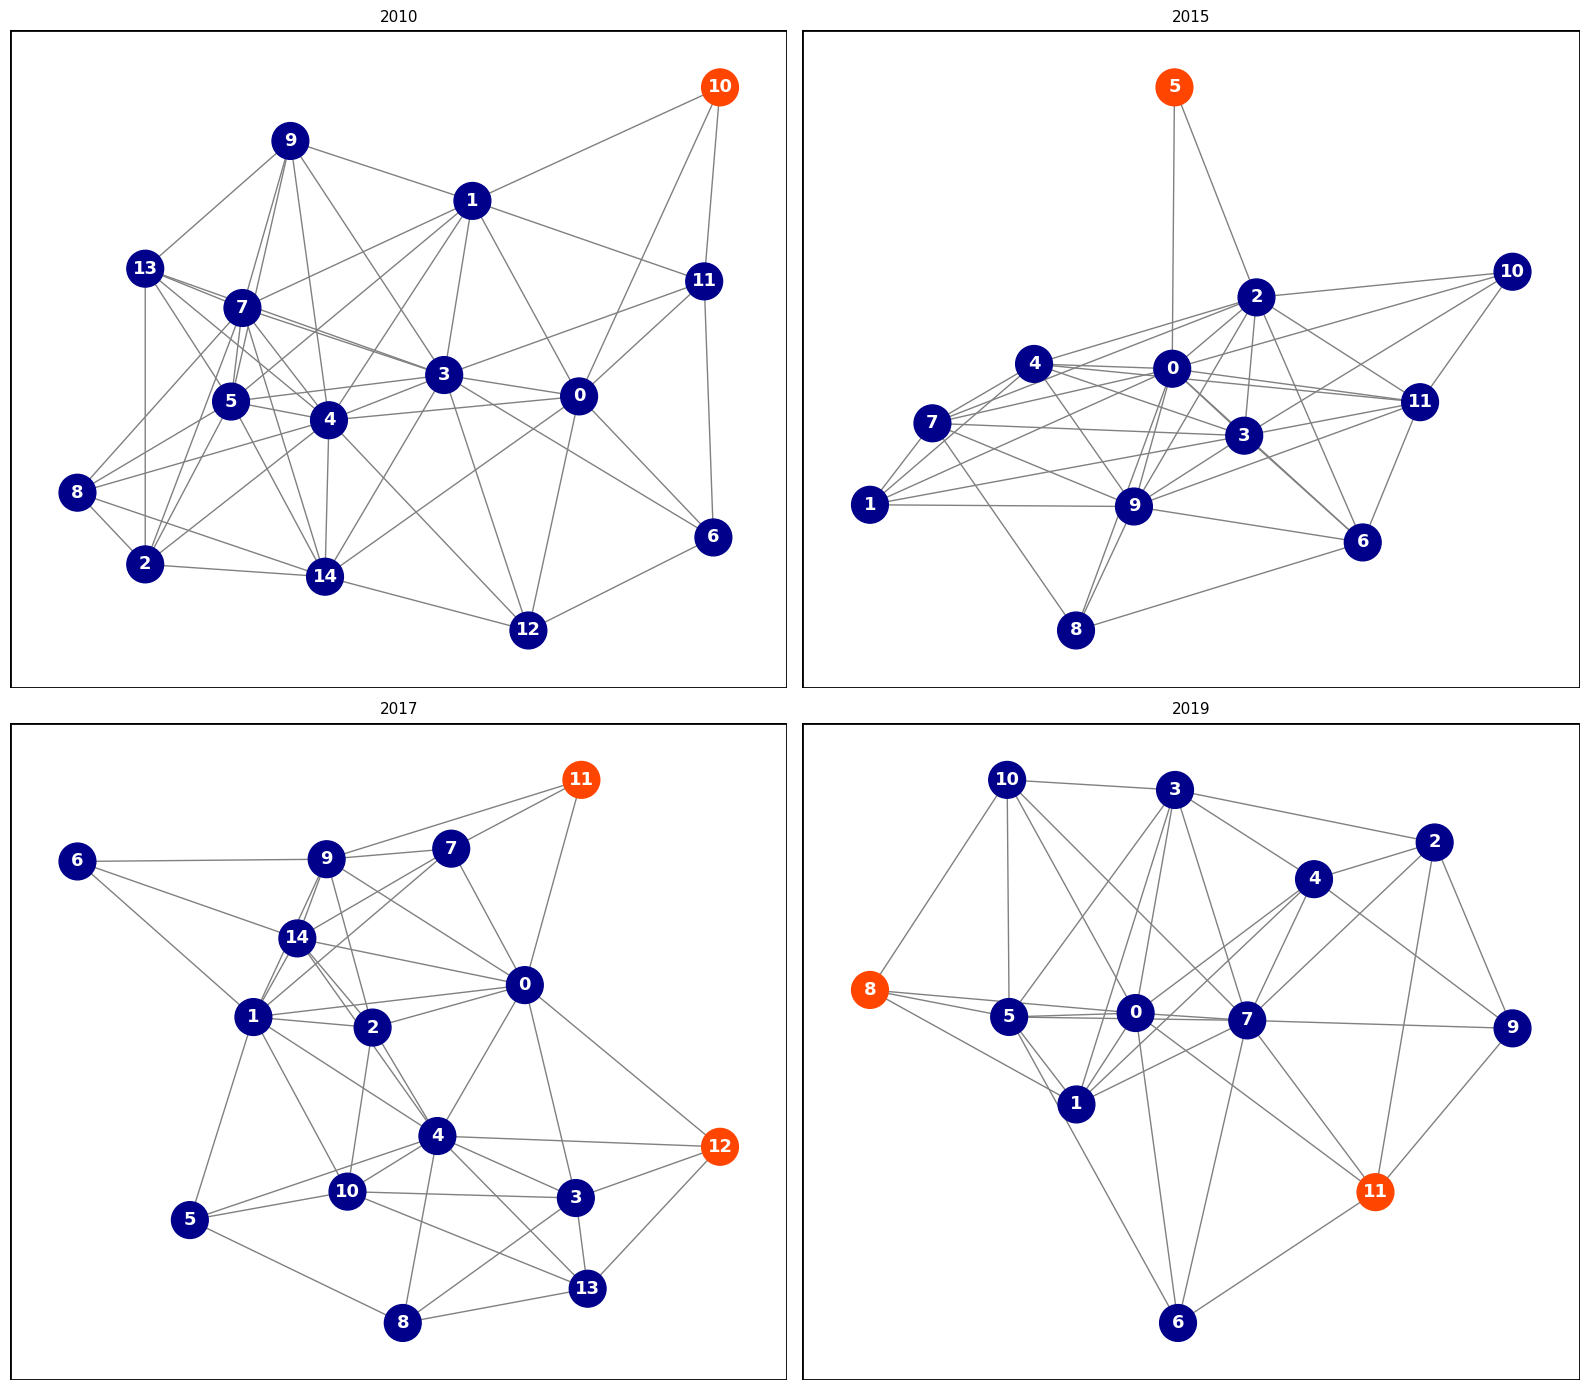

In [166]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()
years = [2010, 2015, 2017, 2019]
bms = [bm2010, bm2015, bm2017, bm2019]
stats = [ball_stats2010_ols, ball_stats2015_ols, ball_stats2017_ols, ball_stats2019_ols]

for i in range(4):
    year = years[i]
    bm = bms[i]
    stats_df = stats[i]
    low_balls = set(stats_df.loc[stats_df['residual_category_combined'] == 'low', 'ball'])

    G = bm.Graph
    pos = nx.spring_layout(G, seed=123)

    node_colors = []
    for node in G.nodes:
        if node in low_balls:
            node_colors.append('#FF4500')  # orange for low model performance
        else:
            node_colors.append('#00008B')  # dark blue for others

    # Draw each subplot
    plt.sca(axes[i])
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=True,
        edge_color='gray',
        node_size=700,
        font_size=13,
        font_color='white',
        font_weight='bold'
    )
    axes[i].set_title(f"{year}", fontsize=11)

    # Add black frame
    rect = plt.Rectangle(
        (0, 0), 1, 1,
        transform=axes[i].transAxes,
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    axes[i].add_patch(rect)

# Final layout
plt.tight_layout()
# plt.savefig("/Users/alexander/Documents/GitHub/turnout-uk/figs/tda/residualsOLS.jpg", format="jpeg", dpi=600)
plt.show()


In [167]:
# Step 1: Define low-performing balls
low_ball_ids = {10}

# Step 2: Add temporary flag for low balls
points2010['low_ball_flag'] = points2010['ball'].isin(low_ball_ids).astype(int)

# % of times
points2010['low_ball_flag'].mean()

0.005069708491761723

In [168]:
# % of time# Step 1: Define low-performing balls
low_ball_ids = {5}

# Step 2: Add temporary flag for low balls
points2015['low_ball_flag'] = points2015['ball'].isin(low_ball_ids).astype(int)

# % of times
points2015['low_ball_flag'].mean()

0.002834467120181406

In [169]:
# % of time# Step 1: Define low-performing balls
low_ball_ids = {11,12}

# Step 2: Add temporary flag for low balls
points2017['low_ball_flag'] = points2017['ball'].isin(low_ball_ids).astype(int)

# % of times
points2017['low_ball_flag'].mean()

0.017487046632124352

In [170]:
# % of time# Step 1: Define low-performing balls
low_ball_ids = {8,11}

# Step 2: Add temporary flag for low balls
points2019['low_ball_flag'] = points2019['ball'].isin(low_ball_ids).astype(int)

# % of times
points2019['low_ball_flag'].mean()

0.02069425901201602

In [171]:
# Combine all points data
all_points = pd.concat(
    [points2010, points2015, points2017, points2019],
    ignore_index=True
)

# Collapse to one row per constituency per year
collapsed_all = (
    all_points
    .sort_values('low_ball_flag', ascending=False)  # prioritise rows with low_ball_flag = 1
    .drop_duplicates(subset=['constituency_geographic_code', 'election_year'])  # keep first = flagged if exists
    .reset_index(drop=True)
)

# collapsed_all.to_csv("/Users/alexander/Documents/MSc Data Science/erp-uom/data/collapsed_all.csv", index=False)

### 2. SEM 2015

/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


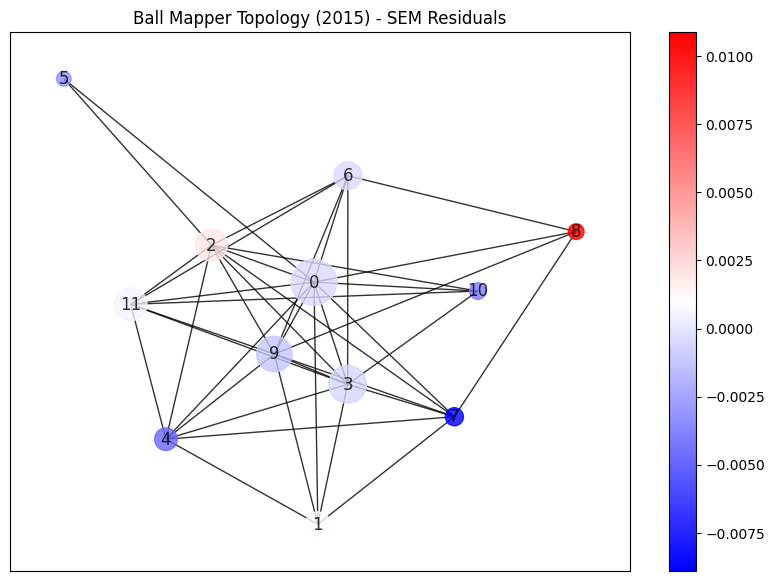

In [173]:
# 1. Define diverging colormap
cmap = plt.cm.bwr
abs_max = np.nanmax(np.abs(df['sem_2015_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 2. Filter 2015 data
df_2015 = df[df['election_year'] == 2015].reset_index(drop=True)
X = df_2015[vars2]
color_df = df_2015[['sem_2015_residuals']]

# 3. Create BallMapper object
bm2015 = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 4. Assign node colours based on residuals
for node in bm2015.Graph.nodes:
    val = bm2015.Graph.nodes[node]['sem_2015_residuals']
    if val is not None and not np.isnan(val):
        bm2015.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2015.Graph.nodes[node]['color'] = "black"

# 5. Plot topology
plt.figure(figsize=(10, 7))
bm2015.draw_networkx(
    coloring_variable='sem_2015_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2015) - SEM Residuals")
plt.show()

# 6. Extract balls and metadata
pb2015 = bm2015.points_and_balls()
df_2015['point'] = df_2015.index
points2015 = df_2015.merge(pb2015, on='point')

ball_summary = points2015.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('sem_2015_residuals', 'mean'),
    abs_residual_mean=('sem_2015_residuals', lambda x: np.mean(np.abs(x))),
    residual_std=('sem_2015_residuals', 'std')
).reset_index()

feature_means = points2015.groupby('ball')[vars2].mean().reset_index()

ball_stats2015_sem = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2015_sem['election_year'] = 2015


In [174]:
# 1. Compute mean and SD of absolute SEM residuals (2015 only)
abs_sem_mean = ball_stats2015_sem['abs_residual_mean'].mean()
abs_sem_sd = ball_stats2015_sem['abs_residual_mean'].std()

# 2. Flag low performing balls (absolute residual > mean + 0.5 * sd)
ball_stats2015_sem['sem_residual_category'] = ball_stats2015_sem['abs_residual_mean'].apply(
    lambda x: 'low' if x > abs_sem_mean + 0.5 * abs_sem_sd else 'normal'
)

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_2860/4002235803.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


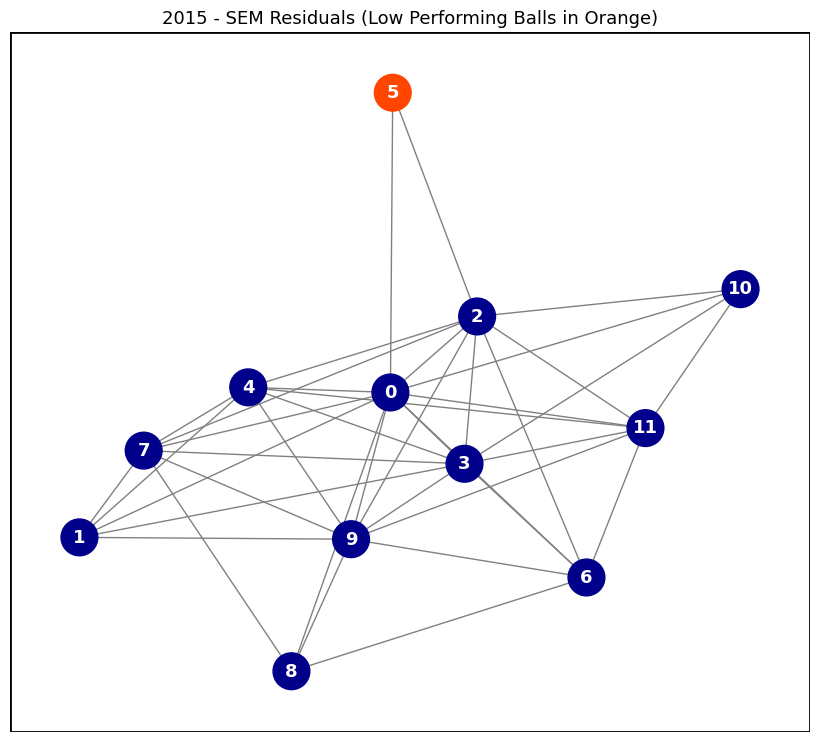

In [175]:
# Create single plot for 2015 SEM residuals
plt.figure(figsize=(8, 7))

# Get graph and low performing balls
G = bm2015.Graph
low_balls = set(ball_stats2015_sem.loc[ball_stats2015_sem['sem_residual_category'] == 'low', 'ball'])

# Layout and color
pos = nx.spring_layout(G, seed=123)
node_colors = [
    '#FF4500' if node in low_balls else '#00008B'
    for node in G.nodes
]

# Draw graph
nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=True,
    edge_color='gray',
    node_size=700,
    font_size=13,
    font_color='white',
    font_weight='bold'
)

plt.title("2015 - SEM Residuals (Low Performing Balls in Orange)", fontsize=13)

# Add black frame
rect = plt.Rectangle(
    (0, 0), 1, 1,
    transform=plt.gca().transAxes,
    linewidth=2,
    edgecolor='black',
    facecolor='none'
)
plt.gca().add_patch(rect)

# Save and show
plt.tight_layout()
# plt.savefig("/Users/alexander/Documents/GitHub/turnout-uk/figs/tda/sem2015_lowBalls.jpg", format="jpeg", dpi=600)
plt.show()


In [176]:
# Step 1: Define low-performing ball based on SEM residuals
low_ball_ids_sem = set(ball_stats2015_sem.loc[
    ball_stats2015_sem['sem_residual_category'] == 'low', 'ball'
])

# Step 2: Add temporary flag for low SEM performance
points2015['low_ball_flag_sem'] = points2015['ball'].isin(low_ball_ids_sem).astype(int)

# Step 3: Calculate percentage of flagged constituencies
percentage_flagged = points2015['low_ball_flag_sem'].mean()
print(f"Percentage of constituencies in low-performing SEM balls: {percentage_flagged:.2%}")

Percentage of constituencies in low-performing SEM balls: 0.28%


In [177]:
# Step 1: Ensure 'low_ball_flag_sem' is present
points2015['low_ball_flag_sem'] = points2015['ball'].isin(low_ball_ids_sem).astype(int)

# Step 2: Keep one row per constituency per year, keeping the flag if it was ever 1
points2015_unique = points2015.groupby('constituency_geographic_code', as_index=False).agg(
    {
        **{col: 'first' for col in points2015.columns if col not in ['constituency_geographic_code', 'low_ball_flag_sem']},
        'low_ball_flag_sem': 'max'  # if any occurrence is 1, retain it
    }
)

# Optional: inspect result
print(points2015_unique['low_ball_flag_sem'].value_counts())

# Export to CSV
# points2015_unique.to_csv(
    "/Users/alexander/Documents/MSc Data Science/erp-uom/data/sem2015_residuals_mapping.csv",
    index=False
)

low_ball_flag_sem
0    645
1      5
Name: count, dtype: int64


### 3. Spatial Lag Models

In [206]:
# 1. Define colormap and vars
cmap = plt.cm.bwr
vars2 = [
    "vote_share_margin", "enp_votes", "total_spending",
    "c11Unemployed", "c11FulltimeStudent", "c11HouseOwned",
    "ethnic_fractionalization", "religious_fractionalization",
    "c11QualLevel4", "age_65_plus", "male"
]

abs_max = np.max(np.abs(df['slag_struct_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 2. Filter for 2010
df_2010 = df[df['election_year'] == 2010].reset_index(drop=True)
X = df_2010[vars2]
color_df = df_2010[['slag_struct_residuals']]

# 3. Create BallMapper object
bm2010_slag = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 4. Assign node colours
for node in bm2010_slag.Graph.nodes:
    val = bm2010_slag.Graph.nodes[node]['slag_struct_residuals']
    if val is not None and not np.isnan(val):
        bm2010_slag.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2010_slag.Graph.nodes[node]['color'] = "black"

# 5. Plot topology
ax = bm2010_slag.draw_networkx(
    coloring_variable='slag_struct_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2010) - SLAG Struct Residuals")
# Close the figure backing that Axes
plt.close(ax.figure)

# 6. Extract ball metadata
pb2010_slag = bm2010_slag.points_and_balls()
df_2010['point'] = df_2010.index
points2010_slag = df_2010.merge(pb2010_slag, on='point')

ball_summary = points2010_slag.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('slag_struct_residuals', 'mean'),
    abs_residual_mean=('slag_struct_residuals', lambda x: np.mean(np.abs(x))),
    residual_std=('slag_struct_residuals', 'std')
).reset_index()

feature_means = points2010_slag.groupby('ball')[vars2].mean().reset_index()

ball_stats2010_slag = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2010_slag['election_year'] = 2010


/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [208]:
# 1. Define colormap and vars
cmap = plt.cm.bwr
vars2 = [
    "vote_share_margin", "enp_votes", "total_spending",
    "c11Unemployed", "c11FulltimeStudent", "c11HouseOwned",
    "ethnic_fractionalization", "religious_fractionalization",
    "c11QualLevel4", "age_65_plus", "male"
]

abs_max = np.max(np.abs(df['slag_struct_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 2. Filter for 2015
df_2015 = df[df['election_year'] == 2015].reset_index(drop=True)
X = df_2015[vars2]
color_df = df_2015[['slag_struct_residuals']]

# 3. Create BallMapper object
bm2015_slag = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 4. Assign node colours
for node in bm2015_slag.Graph.nodes:
    val = bm2015_slag.Graph.nodes[node]['slag_struct_residuals']
    if val is not None and not np.isnan(val):
        bm2015_slag.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2015_slag.Graph.nodes[node]['color'] = "black"

# 5. Plot topology
ax = bm2015_slag.draw_networkx(
    coloring_variable='slag_struct_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2015) - SLAG Struct Residuals")
# Close the figure backing that Axes
plt.close(ax.figure)

# 6. Extract ball metadata
pb2015_slag = bm2015_slag.points_and_balls()
df_2015['point'] = df_2015.index
points2015_slag = df_2015.merge(pb2015_slag, on='point')

ball_summary = points2015_slag.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('slag_struct_residuals', 'mean'),
    abs_residual_mean=('slag_struct_residuals', lambda x: np.mean(np.abs(x))),
    residual_std=('slag_struct_residuals', 'std')
).reset_index()

feature_means = points2015_slag.groupby('ball')[vars2].mean().reset_index()

ball_stats2015_slag = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2015_slag['election_year'] = 2015


/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [210]:
# 1. Define colormap and vars
cmap = plt.cm.bwr
vars2 = [
    "vote_share_margin", "enp_votes", "total_spending",
    "c11Unemployed", "c11FulltimeStudent", "c11HouseOwned",
    "ethnic_fractionalization", "religious_fractionalization",
    "c11QualLevel4", "age_65_plus", "male"
]

abs_max = np.max(np.abs(df['slag_struct_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 2. Filter for 2017
df_2017 = df[df['election_year'] == 2017].reset_index(drop=True)
X = df_2017[vars2]
color_df = df_2017[['slag_struct_residuals']]

# 3. Create BallMapper object
bm2017_slag = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 4. Assign node colours
for node in bm2017_slag.Graph.nodes:
    val = bm2017_slag.Graph.nodes[node]['slag_struct_residuals']
    if val is not None and not np.isnan(val):
        bm2017_slag.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2017_slag.Graph.nodes[node]['color'] = "black"

# 5. Plot topology
ax = bm2017_slag.draw_networkx(
    coloring_variable='slag_struct_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2017) - SLAG Struct Residuals")
# Close the figure backing that Axes
plt.close(ax.figure)

# 6. Extract ball metadata
pb2017_slag = bm2017_slag.points_and_balls()
df_2017['point'] = df_2017.index
points2017_slag = df_2017.merge(pb2017_slag, on='point')

ball_summary = points2017_slag.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('slag_struct_residuals', 'mean'),
    abs_residual_mean=('slag_struct_residuals', lambda x: np.mean(np.abs(x))),
    residual_std=('slag_struct_residuals', 'std')
).reset_index()

feature_means = points2017_slag.groupby('ball')[vars2].mean().reset_index()

ball_stats2017_slag = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2017_slag['election_year'] = 2017


/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [212]:
# 1. Define colormap and vars
cmap = plt.cm.bwr
vars2 = [
    "vote_share_margin", "enp_votes", "total_spending",
    "c11Unemployed", "c11FulltimeStudent", "c11HouseOwned",
    "ethnic_fractionalization", "religious_fractionalization",
    "c11QualLevel4", "age_65_plus", "male"
]

abs_max = np.max(np.abs(df['slag_struct_residuals']))
vmin, vmax = -abs_max, abs_max
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 2. Filter for 2019
df_2019 = df[df['election_year'] == 2019].reset_index(drop=True)
X = df_2019[vars2]
color_df = df_2019[['slag_struct_residuals']]

# 3. Create BallMapper object
bm2019_slag = pbm.BallMapper(X=X, eps=50, coloring_df=color_df)

# 4. Assign node colours
for node in bm2019_slag.Graph.nodes:
    val = bm2019_slag.Graph.nodes[node]['slag_struct_residuals']
    if val is not None and not np.isnan(val):
        bm2019_slag.Graph.nodes[node]['color'] = cmap(norm(val))
    else:
        bm2019_slag.Graph.nodes[node]['color'] = "black"

# 5. Plot topology
ax = bm2019_slag.draw_networkx(
    coloring_variable='slag_struct_residuals',
    color_palette=cmap,
    colorbar=True,
    vmin=vmin,
    vmax=vmax,
    MIN_SCALE=100,
    MAX_SCALE=1000
)
plt.title("Ball Mapper Topology (2019) - SLAG Struct Residuals")
# Close the figure backing that Axes
plt.close(ax.figure)

# 6. Extract ball metadata
pb2019_slag = bm2019_slag.points_and_balls()
df_2019['point'] = df_2019.index
points2019_slag = df_2019.merge(pb2019_slag, on='point')

ball_summary = points2019_slag.groupby('ball').agg(
    n_constituencies=('point', 'count'),
    residual_mean=('slag_struct_residuals', 'mean'),
    abs_residual_mean=('slag_struct_residuals', lambda x: np.mean(np.abs(x))),
    residual_std=('slag_struct_residuals', 'std')
).reset_index()

feature_means = points2019_slag.groupby('ball')[vars2].mean().reset_index()

ball_stats2019_slag = pd.merge(ball_summary, feature_means, on='ball')
ball_stats2019_slag['election_year'] = 2019


/opt/anaconda3/lib/python3.12/site-packages/pyballmapper/ballmapper.py:292: UserWarning: Warning........... order is not a list or numpy array, using default ordering
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


In [214]:
# Step 1: Compute absolute residuals
df['abs_slag_residuals'] = df['slag_struct_residuals'].abs()

# Step 2: Compute per-year mean and SD of abs residuals
slag_abs_mean_sd_table = df.groupby('election_year')['abs_slag_residuals'].agg(['mean', 'std']).reset_index()

# Step 3: Compute global mean and SD of abs residuals
global_slag_abs_mean = df['abs_slag_residuals'].mean()
global_slag_abs_sd = df['abs_slag_residuals'].std()

# Step 4: Local (per-year) classification with 0.5 SD threshold
def tag_abs_slag_residual_category(stats_df, year):
    mean_val = slag_abs_mean_sd_table.loc[slag_abs_mean_sd_table['election_year'] == year, 'mean'].values[0]
    std_val = slag_abs_mean_sd_table.loc[slag_abs_mean_sd_table['election_year'] == year, 'std'].values[0]

    def label(row):
        if row['abs_residual_mean'] > mean_val + 0.5 * std_val:
            return 'low'
        else:
            return 'normal'

    stats_df['residual_category'] = stats_df.apply(label, axis=1)
    return stats_df

# Step 5: Global classification with 0.5 SD threshold
def tag_abs_slag_residual_category_global(stats_df):
    def label(row):
        if row['abs_residual_mean'] > global_slag_abs_mean + 0.5 * global_slag_abs_sd:
            return 'low'
        else:
            return 'normal'

    stats_df['residual_category_global'] = stats_df.apply(label, axis=1)
    return stats_df

# Step 6: Combined classification
def tag_abs_slag_residual_category_combined(stats_df):
    def label(row):
        if row['residual_category'] == 'low' or row['residual_category_global'] == 'low':
            return 'low'
        else:
            return 'normal'
    stats_df['residual_category_combined'] = stats_df.apply(label, axis=1)
    return stats_df

# Step 7: Apply to each year
ball_stats2010_slag = apply_all_abs_residual_labels(ball_stats2010_slag, 2010)
ball_stats2015_slag = apply_all_abs_residual_labels(ball_stats2015_slag, 2015)
ball_stats2017_slag = apply_all_abs_residual_labels(ball_stats2017_slag, 2017)
ball_stats2019_slag = apply_all_abs_residual_labels(ball_stats2019_slag, 2019)

# Step 8: Combine all
ball_stats_slag_all = pd.concat(
    [ball_stats2010_slag, ball_stats2015_slag, ball_stats2017_slag, ball_stats2019_slag],
    ignore_index=True
)


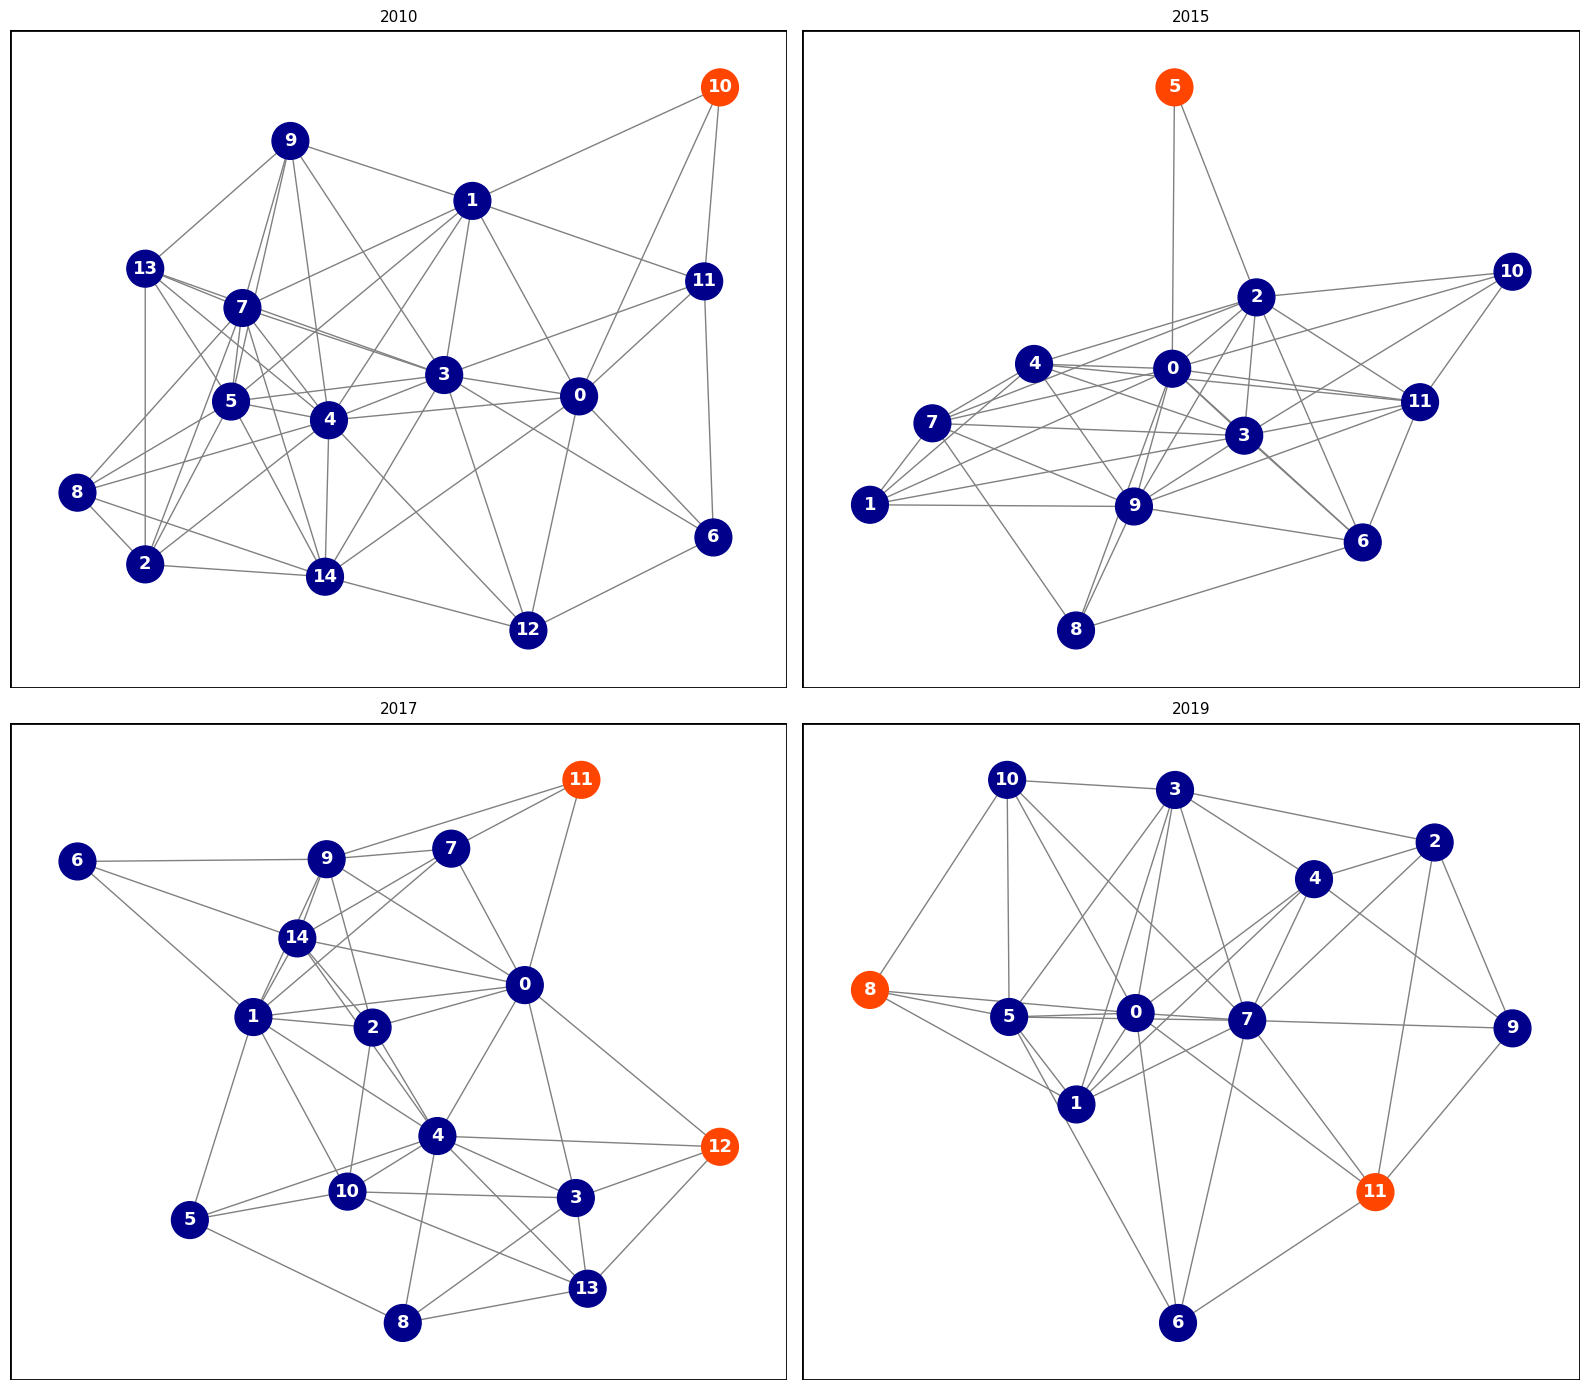

In [216]:
# Create figure with 2x2 subplots for SLAG residuals
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()
years = [2010, 2015, 2017, 2019]
bms = [bm2010_slag, bm2015_slag, bm2017_slag, bm2019_slag]
stats = [ball_stats2010_slag, ball_stats2015_slag, ball_stats2017_slag, ball_stats2019_slag]

for i in range(4):
    year = years[i]
    bm = bms[i]
    stats_df = stats[i]
    low_balls = set(stats_df.loc[stats_df['residual_category_combined'] == 'low', 'ball'])

    G = bm.Graph
    pos = nx.spring_layout(G, seed=123)

    node_colors = []
    for node in G.nodes:
        if node in low_balls:
            node_colors.append('#FF4500')  # orange for low model performance
        else:
            node_colors.append('#00008B')  # dark blue for others

    # Draw each subplot
    plt.sca(axes[i])
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=True,
        edge_color='gray',
        node_size=700,
        font_size=13,
        font_color='white',
        font_weight='bold'
    )
    axes[i].set_title(f"{year}", fontsize=11)

    # Add black frame
    rect = plt.Rectangle(
        (0, 0), 1, 1,
        transform=axes[i].transAxes,
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    axes[i].add_patch(rect)

# Final layout
plt.tight_layout()
# plt.savefig("/Users/alexander/Documents/GitHub/turnout-uk/figs/tda/residualsSLAG.jpg", format="jpeg", dpi=600)
plt.show()


In [218]:
# Step 1: Define low-performing balls
low_ball_ids = {10}

# Step 2: Add temporary flag for low balls
points2010_slag['low_ball_flag'] = points2010_slag['ball'].isin(low_ball_ids).astype(int)

# Step 3: Ensure each constituency appears only once
flagged_2010 = (
    points2010_slag
    .groupby('constituency_geographic_code', as_index=False)
    .agg({
        **{col: 'first' for col in points2010_slag.columns if col not in ['low_ball_flag', 'ball', 'point']},
        'low_ball_flag': 'max'  # If flagged in any appearance, keep it
    })
)

# Step 4: Check proportion flagged
flagged_2010['low_ball_flag'].mean()

0.012307692307692308

In [220]:
# Step 1: Define low-performing balls
low_ball_ids = {5}

# Step 2: Add temporary flag for low balls
points2015_slag['low_ball_flag'] = points2015_slag['ball'].isin(low_ball_ids).astype(int)

# Step 3: Ensure each constituency appears only once
flagged_2015 = (
    points2015_slag
    .groupby('constituency_geographic_code', as_index=False)
    .agg({
        **{col: 'first' for col in points2015_slag.columns if col not in ['low_ball_flag', 'ball', 'point']},
        'low_ball_flag': 'max'  # Keep flag if it ever appears
    })
)

# Step 4: Check proportion flagged
flagged_2015['low_ball_flag'].mean()

0.007692307692307693

In [222]:
# Step 1: Define low-performing balls
low_ball_ids = {11, 12}

# Step 2: Add temporary flag for low balls
points2017_slag['low_ball_flag'] = points2017_slag['ball'].isin(low_ball_ids).astype(int)

# Step 3: Ensure each constituency appears only once
flagged_2017 = (
    points2017_slag
    .groupby('constituency_geographic_code', as_index=False)
    .agg({
        **{col: 'first' for col in points2017_slag.columns if col not in ['low_ball_flag', 'ball', 'point']},
        'low_ball_flag': 'max'  # Keep flag if it ever appears
    })
)

# Step 4: Check proportion flagged
flagged_2017['low_ball_flag'].mean()


0.04153846153846154

In [224]:
# Step 1: Define low-performing balls
low_ball_ids = {8, 11}

# Step 2: Add temporary flag for low balls
points2019_slag['low_ball_flag'] = points2019_slag['ball'].isin(low_ball_ids).astype(int)

# Step 3: Ensure each constituency appears only once
flagged_2019 = (
    points2019_slag
    .groupby('constituency_geographic_code', as_index=False)
    .agg({
        **{col: 'first' for col in points2019_slag.columns if col not in ['low_ball_flag', 'ball', 'point']},
        'low_ball_flag': 'max'  # Keep flag if it ever appears
    })
)

# Step 4: Check proportion flagged
flagged_2019['low_ball_flag'].mean()

0.047692307692307694

In [226]:
# Combine all points data
all_points = pd.concat(
    [flagged_2010, flagged_2015, flagged_2017, flagged_2019],
    ignore_index=True
)

# Collapse to one row per constituency per year
collapsed_all_lag = (
    all_points
    .sort_values('low_ball_flag', ascending=False)  # prioritise rows with low_ball_flag = 1
    .drop_duplicates(subset=['constituency_geographic_code', 'election_year'])  # keep first = flagged if exists
    .reset_index(drop=True)
)

# collapsed_all_lag.to_csv("/Users/alexander/Documents/MSc Data Science/erp-uom/data/collapsed_all_lag.csv", index=False)